In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%autoreload # When utils.py is updated
#from utils_unet_resunet import *
from ops import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from model.callbacks import UpdateWeights
from model.models import ResUNET
from model.losses import WBCE
import matplotlib.pyplot as plt
import time
import tensorflow as tf


In [3]:
root_path = 'imgs/' 

In [4]:
# Define data type (L8-Landsat8, S2-Sentinel2, S1-Sentinel1)
img_type = 'SAR'

if img_type == 'FUSION':
    image_array = np.load(root_path+'New_Images/fus_stack.npy')
    

if img_type == 'OPT':
    image_array = np.load(root_path+'New_Images/opt_stack.npy')
    
    
if img_type == 'SAR':
    image_array = np.load(root_path+'New_Images/sar_stack.npy')
print('Image stack:', image_array.shape)

final_mask1 = np.load(root_path+'New_Images/'+'final_mask1.npy')
print('Labels stack:', final_mask1.shape)



Image stack: (10000, 7000, 4)
Labels stack: (10000, 7000)


In [5]:
lim_x = 10000
lim_y = 7000
image_array = image_array[:lim_x, :lim_y, :]
final_mask1 = final_mask1[:lim_x, :lim_y]
h_, w_, channels = image_array.shape

mask:  (10000, 7000)
image stack:  (10000, 7000, 4)
ref : (10000, 7000)


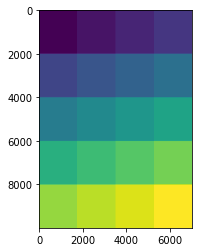

In [6]:
# Create tile mask
mask_tiles = create_mask(final_mask1.shape[0], final_mask1.shape[1], grid_size=(5, 4))
image_array = image_array[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
final_mask1 = final_mask1[:mask_tiles.shape[0], :mask_tiles.shape[1]]

print('mask: ',mask_tiles.shape)
print('image stack: ', image_array.shape)
print('ref :', final_mask1.shape)
plt.imshow(mask_tiles)

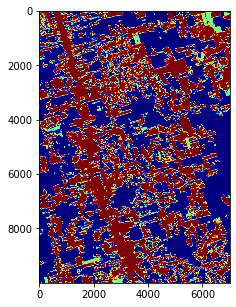

In [7]:
plt.figure(figsize=(10,5))
plt.imshow(final_mask1, cmap = 'jet')

In [8]:
# Define tiles for training, validation, and test sets
tiles_tr = [1,3,5,8,11,13,14,20]
tiles_val = [6,19]
tiles_ts = (list(set(np.arange(20)+1)-set(tiles_tr)-set(tiles_val)))

mask_tr_val = np.zeros((mask_tiles.shape)).astype('float32')
# Training and validation mask
for tr_ in tiles_tr:
    mask_tr_val[mask_tiles == tr_] = 1

for val_ in tiles_val:
    mask_tr_val[mask_tiles == val_] = 2

mask_amazon_ts = np.zeros((mask_tiles.shape)).astype('float32')
for ts_ in tiles_ts:
    mask_amazon_ts[mask_tiles == ts_] = 1

In [9]:
# Create ixd image to extract patches
overlap = 0.7
patch_size = 128
batch_size = 32
im_idx = create_idx_image(final_mask1)

patches_idx = extract_patches(im_idx, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1,patch_size, patch_size) #índice do pixel de cada patch
patches_mask = extract_patches(mask_tr_val, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1, patch_size, patch_size) #1 se pixel for de treinamento 2 se for val
del im_idx

In [10]:
# Selecting index trn val and test patches idx
idx_trn = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==patch_size**2)) #extrai apenas idx dos patches com todos os valores == 1 (train)
idx_val = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==2*patch_size**2)) #extrai apenas idx dos patches com todos os valores == 2 (val)
del patches_mask

patches_idx_trn = patches_idx[idx_trn]
patches_idx_val = patches_idx[idx_val]
del idx_trn, idx_val

print('Number of training patches:  ', len(patches_idx_trn), 'Number of validation patches', len(patches_idx_val))

Number of training patches:   17110 Number of validation patches 4116


In [11]:
# Extract patches with at least 2% of deforestation class
X_train = retrieve_idx_percentage(final_mask1, patches_idx_trn, patch_size, pertentage = 2)
X_valid = retrieve_idx_percentage(final_mask1, patches_idx_val, patch_size, pertentage = 2)
print(X_train.shape, X_valid.shape)
del patches_idx_trn, patches_idx_val

(1158, 128, 128) (341, 128, 128)


In [12]:
train_datagen = ImageDataGenerator(horizontal_flip = True,
                                   vertical_flip = True)
valid_datagen = ImageDataGenerator(horizontal_flip = True, 
                                   vertical_flip = True)

Y_train = np.zeros_like(X_train)
Y_valid = np.zeros_like(X_valid)

train_gen = train_datagen.flow(np.expand_dims(X_train, axis = -1), Y_train,
                              batch_size=batch_size,
                              shuffle=True)

valid_gen = valid_datagen.flow(np.expand_dims(X_valid, axis = -1), Y_valid,
                              batch_size=batch_size,
                              shuffle=False)

number_class = 3


In [13]:
def batch_generator(batches, image, reference, target_size, number_class):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    image = image.reshape(-1, image.shape[-1])
    reference = reference.reshape(final_mask1.shape[0]*final_mask1.shape[1])
    while True:
        batch_x, _ = next(batches)
        batch_x = np.squeeze(batch_x.astype('int64'))
        #print(batch_x.shape)
        batch_img = np.zeros((batch_x.shape[0], target_size, target_size, image.shape[-1]))
        batch_ref = np.zeros((batch_x.shape[0], target_size, target_size, number_class))
        
        for i in range(batch_x.shape[0]):
            if np.random.rand()>0.5:
                batch_x[i] = np.rot90(batch_x[i], 1)
            batch_img[i] = image[batch_x[i]] 
            batch_ref[i] = to_categorical(reference[batch_x[i]] , number_class)
                       
        yield (batch_img, batch_ref)

In [14]:
train_gen_crops = batch_generator(train_gen, image_array, final_mask1, patch_size, number_class)
valid_gen_crops = batch_generator(valid_gen, image_array, final_mask1, patch_size, number_class)

In [15]:
exp = 4
path_exp = root_path+'experiments/exp'+str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)

In [16]:
# Define model
input_shape = (patch_size, patch_size, channels)
nb_filters = [32, 64, 128]

method = 'resunet'
model = ResUNET(nb_filters, number_class)

In [17]:
# Parameters of the model
weights = [0.2, 0.8, 0]
adam = Adam(lr = 1e-3 , beta_1=0.9)
#loss = weighted_categorical_crossentropy(weights)
loss = WBCE(weights = weights)
#loss = WBCE(weights = weights, class_indexes = [0, 1])


In [18]:
metrics_all = []
times=10
for tm in range(0,times):
    print('time: ', tm)
    rows = patch_size
    cols = patch_size
    adam = Adam(lr = 1e-3 , beta_1=0.9)
    loss = WBCE(weights = weights)
    model = ResUNET(nb_filters, number_class)
    model.build((None,)+input_shape)
    model.summary()
    
    # train the model
    start_training = time.time()
    
    model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='min')
    checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
    callbacks_list = [earlystop, checkpoint]
    history = model.fit(train_gen_crops,
                              steps_per_epoch=(3*len(X_train)//train_gen.batch_size),
                              validation_data=valid_gen_crops,
                              validation_steps=(3*len(X_valid)//valid_gen.batch_size),
                              epochs=100,
                              callbacks=callbacks_list)
    
    end_training = time.time() - start_training
    metrics_all.append(end_training)
    del model, history

time:  0
Model: "res_unet_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unet_encoder (ResUNET_Encode multiple                  1054272   
_________________________________________________________________
unet_decoder (ResUNET_Decode multiple                  221408    
_________________________________________________________________
classifier (Classifier)      multiple                  195       
Total params: 1,275,875
Trainable params: 1,275,875
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
108/108 [==============================] - 15s 73ms/step - loss: 0.1488 - accuracy: 0.5797 - val_loss: 0.1206 - val_accuracy: 0.6862.1687 - accuracy: 0.50 - ETA:  - ETA: 0s - loss: 0.1498 - accura

Epoch 00001: val_loss improved from inf to 0.12063, saving model to imgs/experiments/exp4/models\resunet_0.h5
Epoch 2/100
108/108 [==========================

108/108 [==============================] - 12s 112ms/step - loss: 0.0908 - accuracy: 0.7469 - val_loss: 0.1088 - val_accuracy: 0.7058

Epoch 00007: val_loss did not improve from 0.10465
Epoch 8/100
108/108 [==============================] - 12s 111ms/step - loss: 0.0875 - accuracy: 0.7482 - val_loss: 0.1252 - val_accuracy: 0.7199

Epoch 00008: val_loss did not improve from 0.10465
Epoch 9/100
108/108 [==============================] - 12s 113ms/step - loss: 0.0862 - accuracy: 0.7555 - val_loss: 0.1241 - val_accuracy: 0.7143

Epoch 00009: val_loss did not improve from 0.10465
Epoch 10/100
108/108 [==============================] - 12s 114ms/step - loss: 0.0799 - accuracy: 0.7712 - val_loss: 0.1211 - val_accuracy: 0.7198

Epoch 00010: val_loss did not improve from 0.10465
Epoch 11/100
108/108 [==============================] - 12s 116ms/step - loss: 0.0779 - accuracy: 0.7770 - val_loss: 0.1263 - val_accuracy: 0.6940: 0.0

Epoch 00011: val_loss did not improve from 0.10465
Epoch 00011: ea

Epoch 1/100
108/108 [==============================] - 17s 147ms/step - loss: 0.1431 - accuracy: 0.5919 - val_loss: 0.1198 - val_accuracy: 0.6853

Epoch 00001: val_loss improved from inf to 0.11979, saving model to imgs/experiments/exp4/models\resunet_5.h5
Epoch 2/100
108/108 [==============================] - 16s 147ms/step - loss: 0.1186 - accuracy: 0.6821 - val_loss: 0.1076 - val_accuracy: 0.7103

Epoch 00002: val_loss improved from 0.11979 to 0.10758, saving model to imgs/experiments/exp4/models\resunet_5.h5
Epoch 3/100
108/108 [==============================] - 16s 148ms/step - loss: 0.1121 - accuracy: 0.6907 - val_loss: 0.1112 - val_accuracy: 0.7082

Epoch 00003: val_loss did not improve from 0.10758
Epoch 4/100
108/108 [==============================] - 16s 149ms/step - loss: 0.1016 - accuracy: 0.7231 - val_loss: 0.1079 - val_accuracy: 0.7128

Epoch 00004: val_loss did not improve from 0.10758
Epoch 5/100
108/108 [==============================] - 16s 150ms/step - loss: 0.0976 -

108/108 [==============================] - 17s 160ms/step - loss: 0.0871 - accuracy: 0.7601 - val_loss: 0.1200 - val_accuracy: 0.6876

Epoch 00008: val_loss did not improve from 0.10694
Epoch 9/100
108/108 [==============================] - 17s 160ms/step - loss: 0.0836 - accuracy: 0.7666 - val_loss: 0.1188 - val_accuracy: 0.7124

Epoch 00009: val_loss did not improve from 0.10694
Epoch 10/100
108/108 [==============================] - 17s 161ms/step - loss: 0.0810 - accuracy: 0.7698 - val_loss: 0.1211 - val_accuracy: 0.7078

Epoch 00010: val_loss did not improve from 0.10694
Epoch 11/100
108/108 [==============================] - 17s 162ms/step - loss: 0.0805 - accuracy: 0.7692 - val_loss: 0.1313 - val_accuracy: 0.7058

Epoch 00011: val_loss did not improve from 0.10694
Epoch 12/100
108/108 [==============================] - 17s 163ms/step - loss: 0.0788 - accuracy: 0.7709 - val_loss: 0.1301 - val_accuracy: 0.7017

Epoch 00012: val_loss did not improve from 0.10694
Epoch 00012: early 

In [19]:
# Test loop
time_ts = []
n_pool = 3
n_rows = 20#5
n_cols = 16#4
rows, cols = image_array.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_array, pad_width=npad, mode='reflect')

h, w, c = image1_pad.shape
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

input_shape=(patch_size_rows,patch_size_cols, c)

#if method == 'unet':
#   new_model = build_unet(input_shape, nb_filters, number_class)

#if method == 'resunet':
#   new_model = build_resunet(input_shape, nb_filters, number_class)

new_model = ResUNET(nb_filters, number_class)
new_model.build((None,)+input_shape)
adam = Adam(lr = 1e-3 , beta_1=0.9)
loss = WBCE(weights = weights)
#loss = weighted_categorical_crossentropy(weights)
new_model.compile(optimizer=adam, loss=loss, metrics=['accuracy'], run_eagerly=True)

for tm in range(0,times):
    print('time: ', tm)
    #model = load_model(path_models+ '/' + method +'_'+str(tm)+'.h5', compile=False)
    
    #for l in range(1, len(model.layers)):
    #    new_model.layers[l].set_weights(model.layers[l].get_weights())
    new_model.load_weights(path_models+ '/' + method +'_'+str(tm)+'.h5')
    
    start_test = time.time()
    patch_list = []

    
    for i in range(0,num_patches_y):
        for j in range(0,num_patches_x):
            patch = image1_pad[patch_size_rows*j:patch_size_rows*(j+1), patch_size_cols*i:patch_size_cols*(i+1), :]
            pred = new_model.predict(np.expand_dims(patch, axis=0))
            del patch 
            patch_list.append(pred[:,:,:,1])

            del pred
    end_test =  time.time() - start_test

    patches_pred = np.asarray(patch_list).astype(np.float32)
    
    del patch_list

    prob_recontructed = pred_reconctruct(h, w, num_patches_x, num_patches_y, patch_size_rows, patch_size_cols, patches_pred)
    
    del patches_pred
    np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_recontructed) 

    time_ts.append(end_test)
    del prob_recontructed
    #del model
time_ts_array = np.asarray(time_ts)
# Save test time
np.save(path_exp+'/metrics_ts.npy', time_ts_array)


-80.0 -40.0
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9


In [20]:
# Compute mean of the tm predictions maps
prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times))

for tm in range (0, times):
    print(tm)
    prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)


mean_prob = np.mean(prob_rec, axis = -1)

np.save(path_maps+'/prob_mean.npy', mean_prob)

0
1
2
3
4
5
6
7
8
9


(-0.5, 6999.5, 9999.5, -0.5)

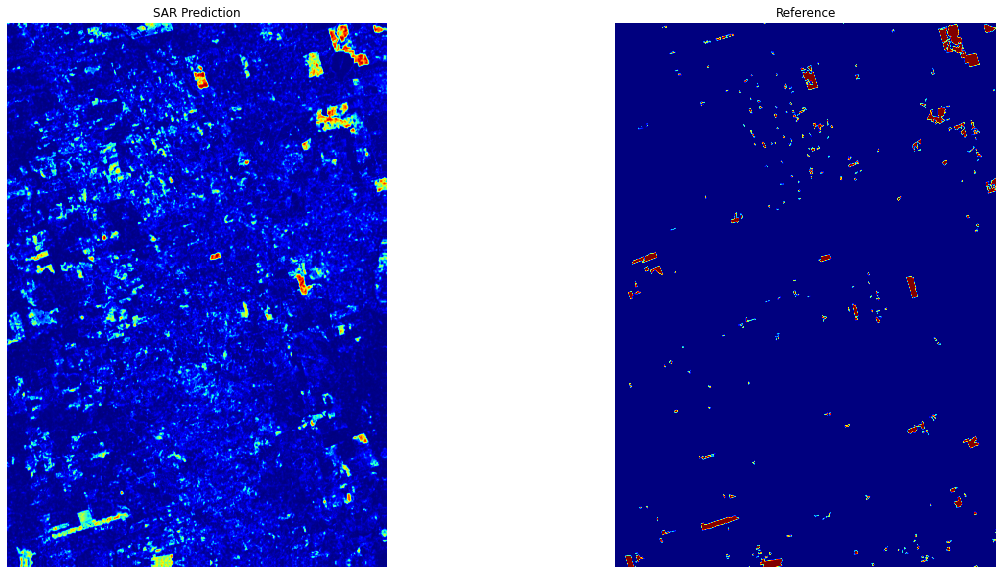

In [21]:
# Plot mean map and reference
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
plt.title(f'{img_type} Prediction')
ax1.imshow(mean_prob, cmap ='jet')
ax1.axis('off')

ax2 = fig.add_subplot(122)
plt.title('Reference')
ax2.imshow(tf.keras.utils.to_categorical(final_mask1, 3)[:,:,1], cmap ='jet')
ax2.axis('off')

In [22]:
# Computing metrics
t0 = time.time()
mean_prob = mean_prob[:final_mask1.shape[0], :final_mask1.shape[1]]


ref1 = np.ones_like(final_mask1).astype(np.float32)

ref1 [final_mask1 == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = final_mask1==1
    
Npoints = 50

Pmax = np.max(mean_prob[GTTruePositives * TileMask ==1])
ProbList = np.linspace(Pmax,0,Npoints)

metrics = metrics_AP(ProbList, mean_prob, final_mask1, mask_amazon_ts, 625)
   
np.save(path_exp+'/acc_metrics.npy',metrics)

print(f'elapsed time: {(time.time()-t0)/60} mins')

elapsed time: 10.752114888032278 mins


In [23]:
# Complete NaN values
metrics_copy = np.array(metrics)
metrics_copy = complete_nan_values(metrics_copy)


SAR mAP 0.842829219990365


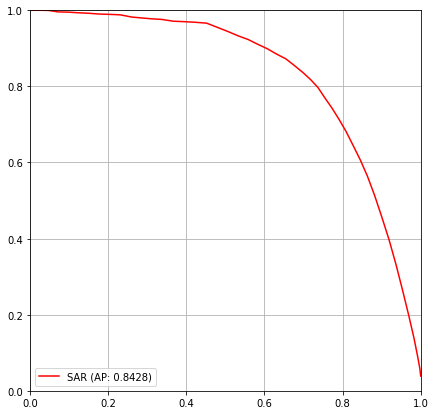

In [24]:
# Comput Mean Average Precision (mAP) score 
Recall = metrics_copy[:,0]
Precision = metrics_copy[:,1]
AA = metrics_copy[:,2]
   
DeltaR = Recall[1:]-Recall[:-1]
AP = np.sum(Precision[:-1]*DeltaR)
print(f'{img_type} mAP', AP)


# Plot Recall vs. Precision curve
plt.figure(figsize=(7,7))
plt.plot(metrics_copy[:,0],metrics_copy[:,1], 'r-', label = f'{img_type} (AP: {AP:.4f})')
plt.legend(loc="lower left")
ax = plt.gca()
ax.set_ylim([0,1])
ax.set_xlim([0,1])
#plt.plot(metrics_copy[:,0],metrics_copy[:,2])
plt.grid()